Import Necessary Packages

In [19]:
import generate_clusters
import generate_plotly
import json
import matplotlib.pyplot as plt
import networkx as nx
import network_graph
import numpy as np
import pandas as pd
import plotly 
import plotly.plotly as py
from plotly.graph_objs import *
import pylab
import set_plotly_credentials as setply
from sklearn.cluster import KMeans

In [20]:
setply.set_plotly_credentials('credentials.json')

Read in Necessary Dataset

In [21]:
filepath = 'https://raw.githubusercontent.com/rmw647/not-that-into-you/master/Speed%20Dating%20Data.csv'
data = pd.read_csv(filepath, encoding='latin1')

Choose which variables you want to cluster on.

In [22]:
bio_info = data[['iid','pid','match','age','sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga','exphappy']]

In [23]:
bio_info = bio_info.dropna(how='any')

Only keep one line of background information data for each participant.

In [24]:
bio_info_subset = bio_info.drop_duplicates(subset='iid')

Select Out the Speed-Dating Matches for Links

In [25]:
matches = bio_info[['iid','pid','match']]
matches = matches[matches.match==1]
matches['pid'] = matches['pid'].astype(int)
matches = matches[matches.iid.isin(bio_info_subset.iid)&matches.pid.isin(bio_info_subset.iid)]
edges = list(zip(matches.iid, matches.pid))

Perform K-means clustering. Normalize and generate cluster labels.

In [55]:
cluster_columns = ['age','sports','tvsports','exercise','dining','museums','art','hiking','gaming','clubbing',
                   'reading','tv','theater','movies','concerts','music','shopping','yoga','exphappy']
number_of_clusters=3
bio_info_subset = generate_clusters.generate_clusters(bio_info,cluster_columns,number_of_clusters,'cluster_assignment')

In [57]:
G, clusters = network_graph(bio_info_subset.iid, edges, bio_info_subset.cluster_assignment,"circles",number_of_clusters,bio_info)

In [58]:
awesome_plot = generate_plotly.generate_plotly(G, clusters)

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~1215Diana/0 or inside your plot.ly account where it is named 'networkx'


In [59]:
awesome_plot

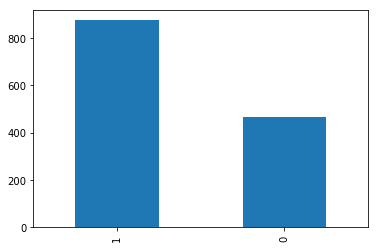

In [67]:
cluster_freq(clusters,matches)